## Installing and importing libraries 

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
import pandas as pd
import os 
import torch
import torchvision
from torch.utils.data import Dataset ,DataLoader
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

##Download Dataset

In [ ]:
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > Asg2_Dataset.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3639M  100 3639M    0     0   137M      0  0:00:26  0:00:26 --:--:--  131M


In [ ]:
!unzip Asg2_Dataset.zip

In [ ]:
!pip install wandb
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=c950b0ef85959e8fd85d62ec7ca203ce703249b72e9cf123505f6036773c6143
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


## Setting up the wandb Sweep

In [ ]:

wandb.login(key="a2e6402ce9fe2ebe1f01d5332c4fafa210b0dc0c")
pName = "Assignment 2 Part A main best hyperparameters final with grid"
run_obj=wandb.init( project=pName)

# Set up the configuration for the sweep using the `wandb.sweep` function
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val accuracy', 'goal': 'maximize'},
    'parameters': {
        'drop_out': {"values": [0.2, 0.3]},
        "activation_function": {
              "values": [ "ReLU", "SiLU", "GELU", "Mish"]
          },
          
          "learning_rate": {
              "values": [1e-3, 1e-4]
          }
          ,
        "filter_organisation":{
            "values":["[4,8,16,32,64],[64,32,16,8,4],[32,32,32,32,32],[64,64,64,64,64]"]
        },
       
        "data_augmentation":{
            "values":["Yes","No"]
        },
        "batch_normalization":{
            "values":["Yes","No"]
        },
          "epochs": {
              "values": [5, 10]
          },
    }
}



wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs22m008. Use `wandb login --relogin` to force relogin


##CNN model 

In [ ]:
import statistics

class CNNModel(pl.LightningModule):
    
    def __init__(self,activation_function,batch_normalization,data_augmentation,filter_organisation,drop_out):

        self.val_loss=[]
        self.train_loss=[]

        self.activation_function=activation_function
        self.batch_normalization=batch_normalization
        
        self.train_accuracy=[]
        self.val_accuracy=[]

        super(CNNModel, self).__init__()
        
        self.cnv1 = torch.nn.Conv2d(3, filter_organisation[0], 3)
        self.cnv2 = torch.nn.Conv2d(filter_organisation[0], filter_organisation[1], 3)
        self.cnv3 = torch.nn.Conv2d(filter_organisation[1], filter_organisation[2], 3)      
        self.cnv4 = torch.nn.Conv2d(filter_organisation[2], filter_organisation[3], 3)
        self.cnv5 = torch.nn.Conv2d(filter_organisation[3], filter_organisation[4], 3)
        
        if(activation_function=="ReLU"):
            self.activation_function=nn.ReLU()
        elif(activation_function=="GELU"):
            self.activation_function=nn.GELU()
        elif(activation_function=="SiLU"):
            self.activation_function=nn.SiLU()
        elif(activation_function=="Mish"):
            self.activation_function=nn.Mish()
        
        stride=2
        input_size=256
        
        DenseLayerSize=input_size
        for filter in filter_organisation:
            DenseLayerSize = (DenseLayerSize-4)//stride + 1
        
        self.bn = nn.BatchNorm1d(DenseLayerSize*DenseLayerSize*filter_organisation[4])
        self.mxpool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc= nn.Linear(DenseLayerSize*DenseLayerSize*filter_organisation[4],10)
        self.softmax = nn.Softmax()
        self.learning_rate=0.001
        self.dropout = nn.Dropout(p=drop_out)
        self.save_hyperparameters()

    def forward(self,x):
        out=self.activation_function(self.cnv1(x))
        out=self.mxpool(out)

        out=self.activation_function(self.cnv2(out))
        out=self.mxpool(out)

        out=self.activation_function(self.cnv3(out))
        out=self.mxpool(out)

        out=self.activation_function(self.cnv4(out))
        out=self.mxpool(out)

        out=self.activation_function(self.cnv5(out))
        
        out = self.mxpool(out)
        out=self.flat(out)
        if(self.batch_normalization=="Yes"):
            out=self.bn(out) 
        out = self.dropout(out)

        out = self.activation_function(self.fc(out))
        return out
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_loss.append(loss)
        accuracy = (logits.argmax(dim=1) == y).float().mean()
        self.train_accuracy.append(accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_loss.append(loss)

        accuracy = (logits.argmax(dim=1) == y).float().mean()
        self.val_accuracy.append(accuracy)


    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("test loss",loss, prog_bar=True)
        accuracy = (logits.argmax(dim=1) == y).float().mean()
        self.log("test accuracy",accuracy, prog_bar=True)



    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def on_train_epoch_end(self):

      train_loss=torch.stack(self.train_loss).mean()
      self.train_loss=[]

      val_loss=torch.stack(self.val_loss).mean()
      self.val_loss=[]

      train_accuracy=torch.stack(self.train_accuracy).mean()
      self.train_accuracy=[]


      val_accuracy=torch.stack(self.val_accuracy).mean()
      self.val_accuracy=[]

      wandb.log({"train loss":train_loss,"train accuracy":train_accuracy,"val loss":val_loss,"val accuracy":val_accuracy})


## Training the model with best parameters obtained by wandb sweep

In [ ]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256,256)),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transform_augmented = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.AutoAugment(),

    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Load dataset from directory
dataset = datasets.ImageFolder('/content/inaturalist_12K/train', transform=transform)

test_dataset = datasets.ImageFolder('/content/inaturalist_12K/val', transform=transform)

# Split dataset into training and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

# Create data loader objects for training and testing sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)




obj = CNNModel("Mish","Yes","No",[64,64,64,64,64], 0.2)
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1)
trainer.fit(model=obj,train_dataloaders=train_dataloader,val_dataloaders=val_dataloader)
trainer.test(obj,  test_dataloader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                | Type        | Params
-----------------------------------------------------
0  | cnv1                | Conv2d      | 1.8 K 
1  | cnv2                | Conv2d      | 36.9 K
2  | cnv3                | Conv2d      | 36.9 K
3  | cnv4                | Conv2d      | 36.9 K
4  | cnv5                | Conv2d      | 36.9 K
5  | activation_function | Mish        | 0     
6  | bn                  | BatchNorm1d | 4.6 K 
7  | mxpool              | MaxPool2d   | 0     
8  | flat                | Flatten     | 0     
9  | fc    

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test accuracy       │    0.3714999854564667     │
│         test loss         │    1.9693703651428223     │
└───────────────────────────┴───────────────────────────┘

[{'test accuracy': 0.3714999854564667, 'test loss': 1.9693703651428223}]

## Display a grid of 10x3 images and their predictions


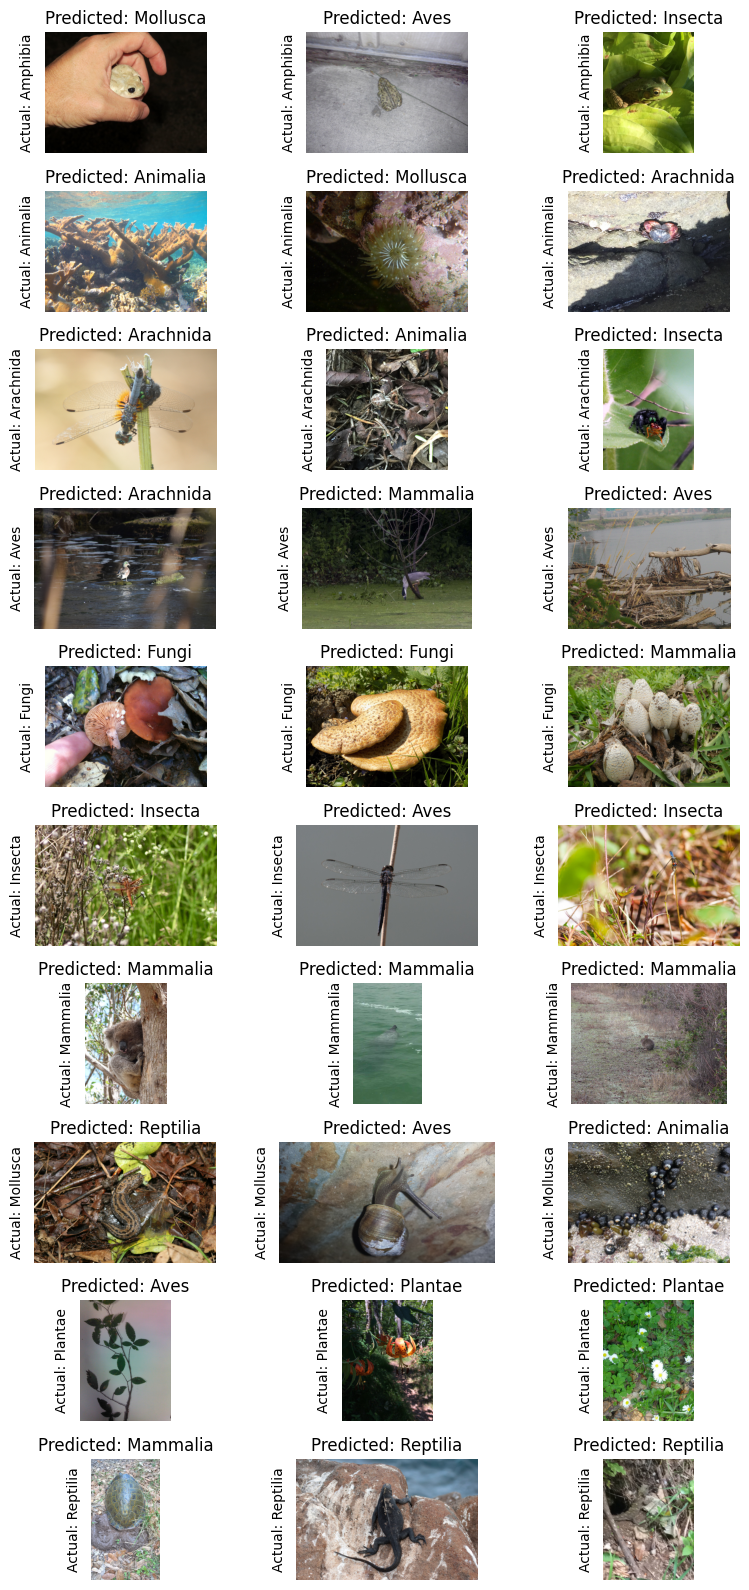

In [ ]:
labels=["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(8, 16))
j = -1
for i, ax in enumerate(axes.flat):
    if (i%3 == 0):
      j= j+1
    
    folder_path = "/content/inaturalist_12K/train/"+labels[j] 
    file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    random_file = random.choice(file_list)

    image = Image.open(folder_path+'/'+random_file)
    image_t= transform(image)
    obj.eval()
    image_t = image_t.reshape(1,3,256,256)
    predictions = obj.forward(image_t)
    ax.imshow(image)

    ax.tick_params(axis='both', which='both', length=0)
    ax.xaxis.set_visible(False,)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_ylabel(f'Actual: {labels[j]}')

    predicted_class = torch.argmax(predictions).item()
    ax.set_title(f'Predicted: {labels[predicted_class]}')

    ax.set_yticklabels([])

plt.tight_layout()
wandb.log({"Grid2": wandb.Image(plt)})

plt.show()


##Wandb Sweep

In [ ]:
def sweep():
    wandb.init()
    config = wandb.config

    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize((256,256)),

        transforms.ToTensor(),

        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    transform_augmented = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.AutoAugment(),

        transforms.ToTensor(),

        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])


    # Load dataset from directory
    if(config.data_augmentation=="No"):
        dataset = datasets.ImageFolder('/content/inaturalist_12K/train', transform=transform)
    else:
        dataset = datasets.ImageFolder('/content/inaturalist_12K/train', transform=transform_augmented)

    test_dataset = datasets.ImageFolder('/content/inaturalist_12K/val', transform=transform)



    # Split dataset into training and testing sets
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

    # Create data loader objects for training and testing sets
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


    print(config.activation_function,config.batch_normalization,config.data_augmentation,config.filter_organisation, config.drop_out)
    
    obj = CNNModel(config.activation_function,config.batch_normalization,config.data_augmentation,config.filter_organisation, config.drop_out)
    
    trainer = pl.Trainer(max_epochs=config.epochs, accelerator="gpu", devices=1)
    
    trainer.fit(model=obj,train_dataloaders=train_dataloader,val_dataloaders=val_dataloader)

    run_name = "lr_{}_ac_{}_bn_{}_da_{}_bs_{}_dp_{}".format(config.learning_rate, config.activation_function,config.batch_normalization,config.data_augmentation,config.filter_organisation, config.drop_out)
    print(run_name)
    wandb.run.name = run_name
    wandb.run.save()

# Initialize the WandB sweep
sweep_id = wandb.sweep(sweep_config,project=pName)
wandb.agent(sweep_id, sweep)